In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os
import cv2
import keras
from keras import layers
import tensorflow as tf
import graphviz
import pydot
import os
import sys

In [2]:
import skimage

In [3]:
sys.path.insert(0, '..')
from function import create_new_folder

In [4]:
#generate a dataset
image_path = r'..\images'
img_size = (180, 180)
batch = 32
class_size = len(os.listdir(image_path))

In [ ]:
#add function for processing corrupt data
#this is a function of pre-processing

In [18]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    image_path,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.5,
    subset="training",
    seed=15,
    image_size=img_size,
    batch_size=batch,
    shuffle='False'
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    image_path,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.1,
    subset="validation",
    seed=15,
    image_size=img_size,
    batch_size=batch,
    shuffle='False'
)
#question, how do i know that the image_dataset_from_directory
#does not have a subset in training that is also in the validation set; validation should be sampled from training set
#create a test set in the folders for images that the model has not seen AT ALL

Found 1776 files belonging to 31 classes.
Using 888 files for training.
Found 1776 files belonging to 31 classes.
Using 177 files for validation.


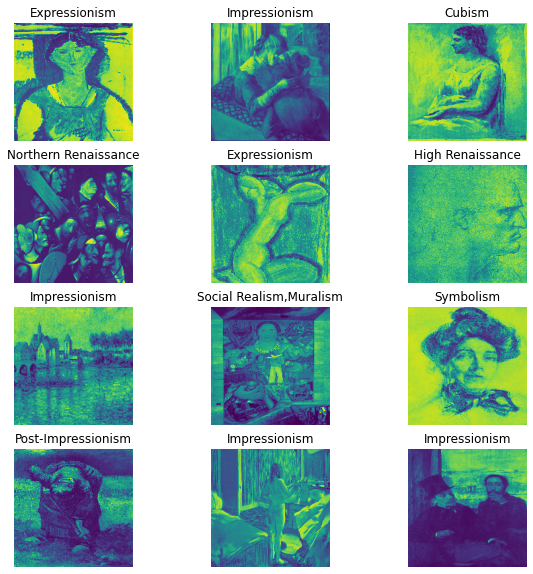

In [19]:
#visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds1.class_names[decode_one_hot(labels[i])])
        plt.axis("off")

In [20]:
#data augmentation using four layers
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.RandomContrast(factor=0.3),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2), fill_mode='reflect'),
    layers.experimental.preprocessing.RandomCrop(height=150, width=150),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomWidth(factor=0.2),
    ])

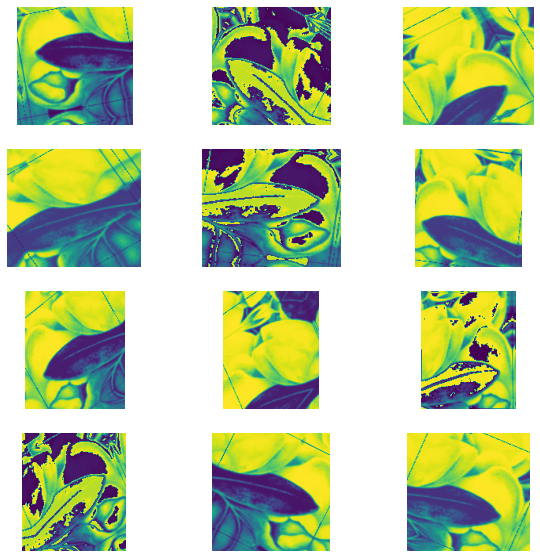

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [36]:
#Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

augmented_train_ds = train_ds.map(
lambda x, y: (data_augmentation(x, training=True), y))

#With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.
#If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.
#In our case, we'll go with the first option.

In [37]:
#Configure the dataset for performance
#Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [38]:
model1 = '../models/model1'
create_new_folder(model1)

../models/model1 path already exists


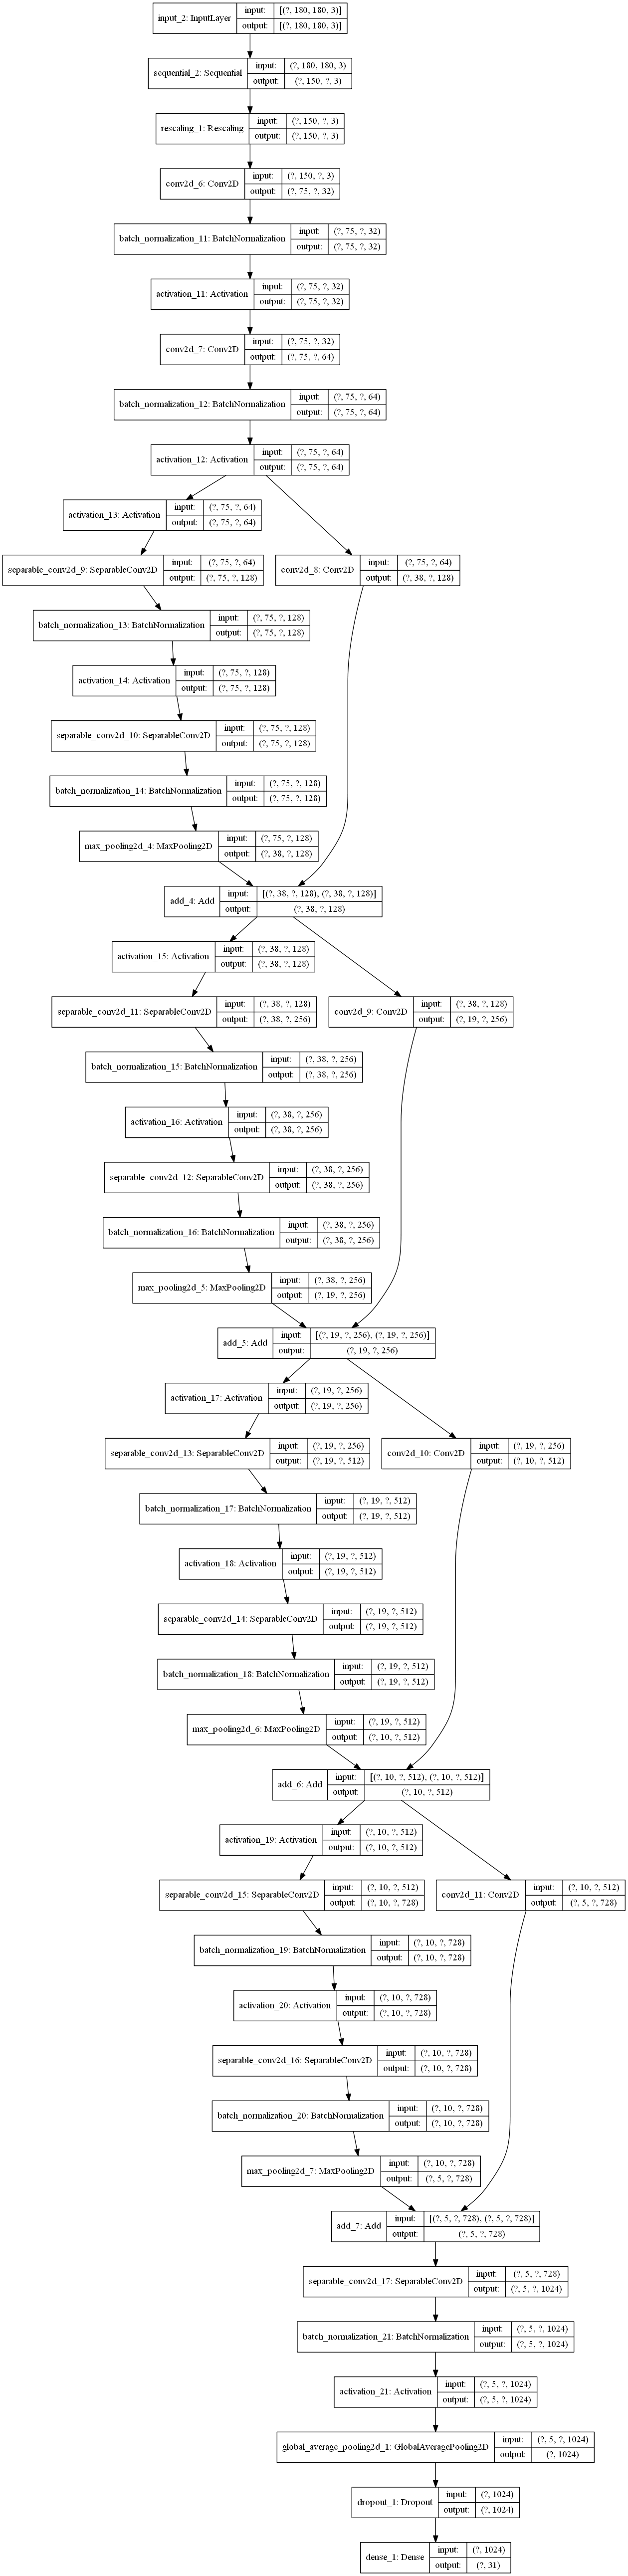

In [39]:
#Build a model
#We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; 
#if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

#Note that:
#We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
#We include a Dropout layer before the final classification layer.
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=img_size + (3,), num_classes=31)
keras.utils.plot_model(model, show_shapes=True)

In [41]:
#Train the model
epochs = 50

callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(model1,f'checkpoint_{epochs}.h5')),]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",#needs to be categorical
              metrics=["accuracy"], #research other metrics
             )

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,)

Epoch 1/50
28/28 [==============================] - 131s 5s/step - loss: 48.7943 - accuracy: 0.0360 - val_loss: 42.7689 - val_accuracy: 0.0282
Epoch 2/50
28/28 [==============================] - 130s 5s/step - loss: 47.5682 - accuracy: 0.0248 - val_loss: 42.7687 - val_accuracy: 0.0282
Epoch 3/50
28/28 [==============================] - 128s 5s/step - loss: 46.9970 - accuracy: 0.0360 - val_loss: 42.7687 - val_accuracy: 0.0282
Epoch 4/50
28/28 [==============================] - 124s 4s/step - loss: 46.7306 - accuracy: 0.0383 - val_loss: 42.7687 - val_accuracy: 0.0282
Epoch 5/50
28/28 [==============================] - 127s 5s/step - loss: 46.6434 - accuracy: 0.0315 - val_loss: 42.7687 - val_accuracy: 0.0282
Epoch 6/50
28/28 [==============================] - 131s 5s/step - loss: 46.6143 - accuracy: 0.0417 - val_loss: 42.7687 - val_accuracy: 0.0282
Epoch 7/50
28/28 [==============================] - 133s 5s/step - loss: 46.6017 - accuracy: 0.0304 - val_loss: 42.7687 - val_accuracy: 0.0282

Notes:
    Accuracy is very low #used categorial cross entropy for loss; research what this is
    Is accuracy more important the less data there is? how many epochs should I be iterating through? is this based on the size of the data set?
    Look at other models #resnet, cnn, rnn
    Perform more exploratory data analysis and augmentation
    create a smaller data set from sample images #done
    understand what epochs are and how this is training the model
    need to figure out if you have bandwidth on computer to look at more pictures

In [43]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomCrop(height=150, width=150),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomWidth(factor=0.2),
    ])

In [44]:
augmented_train_ds1 = train_ds1.map(
lambda x, y: (data_augmentation(x, training=True), y))

In [45]:
train_ds1 = train_ds1.prefetch(buffer_size=32)
val_ds1 = val_ds1.prefetch(buffer_size=32)

In [46]:
model2 = '../models/model2'
create_new_folder(model2)

../models/model2 created


In [47]:
#Train the model
epochs = 50

callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(model2,f'checkpoint_{epochs}.h5')),]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",#needs to be categorical
              metrics=["accuracy"], #research other metrics
             )

model.fit(train_ds1, epochs=epochs, callbacks=callbacks, validation_data=val_ds1,)

Epoch 1/50
28/28 [==============================] - 130s 5s/step - loss: 3.2321 - accuracy: 0.1351 - val_loss: 4.2863 - val_accuracy: 0.0960
Epoch 2/50
28/28 [==============================] - 127s 5s/step - loss: 3.0668 - accuracy: 0.1700 - val_loss: 15.2540 - val_accuracy: 0.0113
Epoch 3/50
28/28 [==============================] - 131s 5s/step - loss: 2.9979 - accuracy: 0.1824 - val_loss: 11.8714 - val_accuracy: 0.0395
Epoch 4/50
28/28 [==============================] - 127s 5s/step - loss: 2.8547 - accuracy: 0.2005 - val_loss: 12.0589 - val_accuracy: 0.0169
Epoch 5/50
28/28 [==============================] - 127s 5s/step - loss: 2.7671 - accuracy: 0.2230 - val_loss: 21.7152 - val_accuracy: 0.0226
Epoch 6/50
28/28 [==============================] - 125s 4s/step - loss: 2.6804 - accuracy: 0.2309 - val_loss: 10.2985 - val_accuracy: 0.0508
Epoch 7/50
28/28 [==============================] - 130s 5s/step - loss: 2.6891 - accuracy: 0.2320 - val_loss: 6.8341 - val_accuracy: 0.0508
Epoch 8/

In [4]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

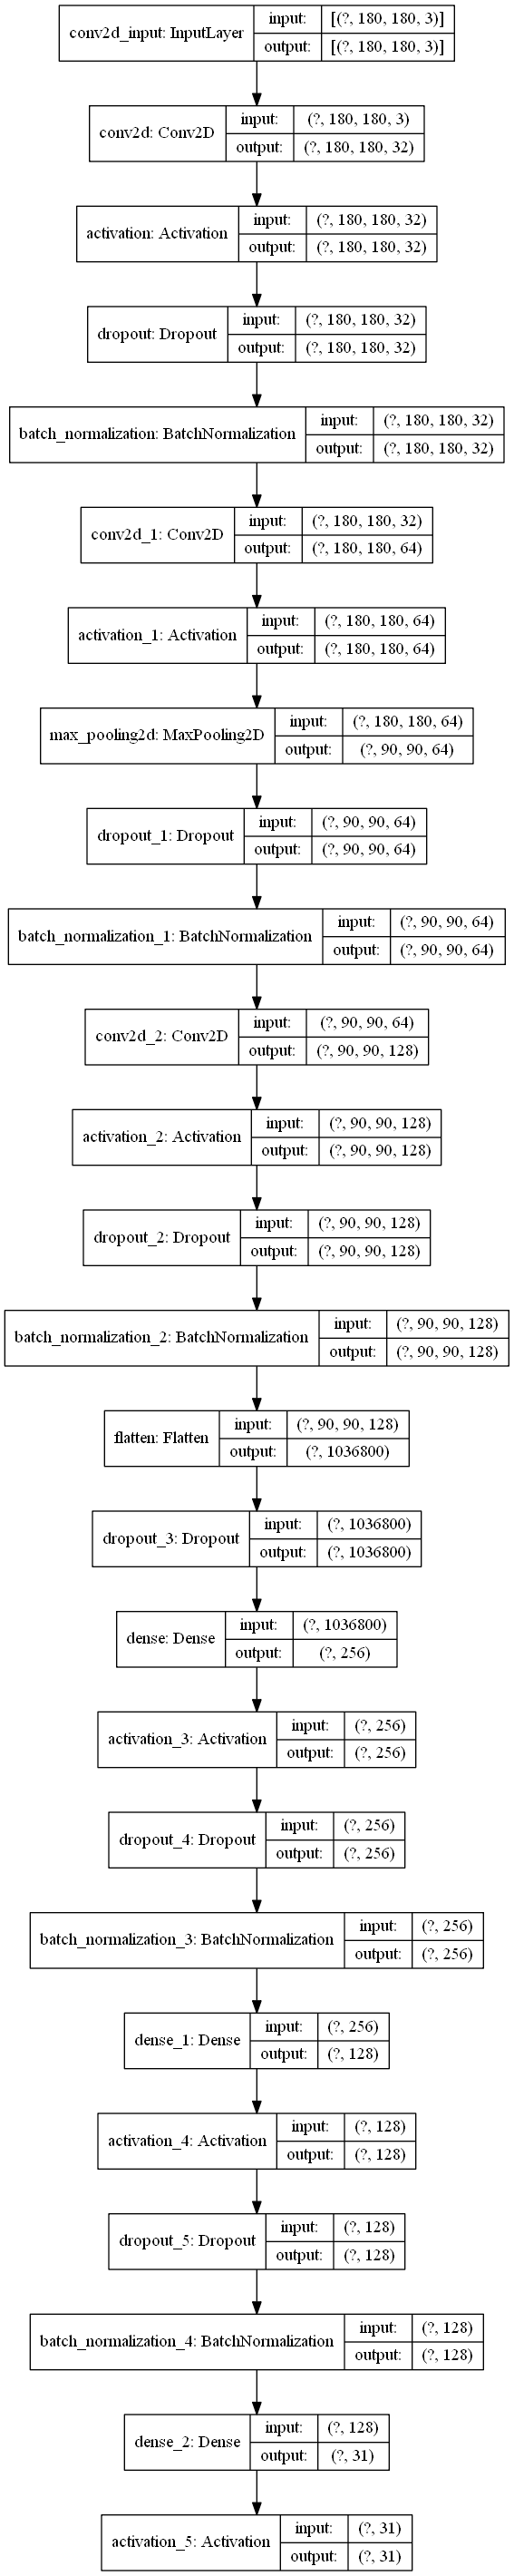

In [8]:
#sequential model for CNN
def seq_model(input_shape, num_classes):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, kernel_constraint=maxnorm(3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(128, kernel_constraint=maxnorm(3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model #check that this works


model_cnn = seq_model(input_shape=img_size + (3,), num_classes=class_size)
keras.utils.plot_model(model_cnn, show_shapes=True)

In [9]:
model3 = '../models/model3'
create_new_folder(model3)

../models/model3 path already exists


In [10]:
epochs = 1 #test

callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(model3,f'checkpoint_{epochs}.h5')),]

model_cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",#needs to be categorical
              metrics=["accuracy"], #research other metrics
             )

model_cnn.fit(train_ds1, epochs=epochs, callbacks=callbacks, validation_data=val_ds1,)
print(model.summary())

28/28 [==============================] - 514s 18s/step - loss: 3.5793 - accuracy: 0.1126 - val_loss: 14.5914 - val_accuracy: 0.0395
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 180, 180, 64)      0

In [8]:

def decode_one_hot(batch_of_vectors):
    #Computes indices for the non-zero entries in batched one-hot vectors.
    '''
    Args:
    batch_of_vectors: A Tensor with length-N vectors, having shape [..., N].
    Returns:
    An integer Tensor with shape [...] indicating the index of the non-zero
    value in each vector.
    '''
    nonzero_indices = tf.where(tf.not_equal(batch_of_vectors, tf.zeros_like(batch_of_vectors)))
    reshaped_nonzero_indices = tf.reshape(nonzero_indices[:, -1], tf.shape(batch_of_vectors)[:-1])
    
    return reshaped_nonzero_indices

#with tf.Session():
#  print(decode_one_hot(one_hot_encoded).eval())

In [ ]:
#evaluate the model
#scores = model.evaluate(X_test, y_test, verbose=0) #create an X_test, y_test
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#only do up to 25 epochs for ~2000 images
#figure out the bug in code when getting a percentage of the pictures
#create a histogram of accuracy of an image for the 21 classes
#create aoc or roc curve
#fix categorical model predictions and reload models

In [15]:
model2 = '../models/model2'

In [16]:
recon_model=keras.models.load_model(os.path.join(model2,f'checkpoint_50.h5'))

In [27]:
img = keras.preprocessing.image.load_img('..\raw_images\Edvard_Munch\Edvard_Munch_67.jpg', target_size=img_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = recon_model.predict(img_array)

0.00014100824046181515

In [ ]:
'''score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)'''

In [ ]:
#num_skipped = 0

#for folder_name in os.listdir(image_path):
#    folder_path = os.path.join(image_path, folder_name)
#    for fname in os.listdir(folder_path):
#        fpath = os.path.join(folder_path, fname)
#        try:
#            fobj = open(fpath, "rb")
#            is_jog = tf.compat.as_bytes("JPG") in fobj.peek(10)
#        finally:
#            fobj.close()
#
#        if not is_jfif:
#            num_skipped += 1
#            # Delete corrupted image
#            os.remove(fpath)

#print("Deleted %d images" % num_skipped)

In [ ]:
'''img = load_img(df.filepath[20])
#x = img_to_array(img)
#x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
it = datagen.flow(x, batch_size=1)

plt.figure(figsize=(10,10))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    #batch=it.next()
    plt.imshow(batch[0].astype("uint8"))
    plt.axis("off")'''

In [ ]:
#create data augmentation
'''datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                             height_shift_range=0.2, brightness_range=(0.1, 1.0),rescale=1./255, 
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, 
                             fill_mode='nearest')'''

In [ ]:
#create image generator
#train_generator = datagen.flow_from_directory(directory=image_path, target_size=image_size, 
#                                              class_mode='categorical', batch_size = batch_size, seed=42)
#will need to figure out why the counts aren't matching up...

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d
https://keras.io/guides/transfer_learning/
https://keras.io/guides/preprocessing_layers/#image-data-augmentation-ondevice
https://keras.io/examples/vision/image_classification_from_scratch/
https://keras.io/guides/sequential_model/
https://towardsdatascience.com/data-augmentation-in-medical-images-95c774e6eaae
https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function
https://stackabuse.com/image-recognition-in-python-with-tensorflow-and-keras/

sources: 
-https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2
-https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
-https://keras.io/examples/vision/image_classification_from_scratch/
-https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
-https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

https://stackoverflow.com/questions/42092508/how-can-i-encode-labels-in-tensorflow
https://stackoverflow.com/questions/53897596/how-to-reverse-one-hot-encoded-value-to-label

https://www.tensorflow.org/guide/keras/save_and_serialize